## Setup Code

In [17]:
using Pkg 
pkg"instantiate" # makes sure all relevant packages are installed

In [18]:
using Parameters, Distributions, Plots

# load auxiliary code 
include("population.jl")

# utility function
function u(type, x) # x is coverage level on [0, 1]
    @unpack M, H, S, A = type # type is unordered named tuple, e.g. (A = 1, M = 2, H = 3, S = 4)
    return x * M + x^2 * 0.5 * H + 0.5 * x * (2 - x) * S^2 * A
end

# cost function
c(type, x) = x * type.M 

c (generic function with 1 method)

In [19]:
# generates a sampler object from which we can draw types 
# works by taking an inverse CDF for M (the health shock), and setting the other parameters to known distribution objects
function genDist(inverseCDF = identity;
                    aDistribution = LogNormal(),
                    hDistribution = LogNormal(),
                    sDistribution = LogNormal())
   
    # return no argument function
    return () -> (M = inverseCDF(rand()), S = rand(sDistribution), A = rand(aDistribution), H = rand(hDistribution))    
end

genDist (generic function with 2 methods)

In [20]:
inverter(icdf1, icdf2) = x -> 

LoadError: syntax: incomplete: premature end of input

In [21]:
contracts = 0.:0.04:1.

0.0:0.04:1.0

## Run Experiment

### High Types

In [22]:
highInverseCDF = x -> sqrt(x)

#41 (generic function with 1 method)

In [23]:
highMean = genDist(highInverseCDF, sDistribution = Normal(2))
highPop = population(highMean, 10000, contracts, u, c);
highEq = equilibrium(highPop, tolerance = 0.01, maxIterations = 10^5); # tolerance from Azvezedo et al is 10
@show highEq.error;

Iteration Budget:  2%|▊                                 |  ETA: 0:07:09
  iter:   2285
  error:  0.01269342908825746

highEq.error = 0.009991758976416985


### Low Types

In [24]:
lowInverseCDF = x -> 1 - sqrt(1 - x)

#43 (generic function with 1 method)

In [25]:
lowMean = genDist(lowInverseCDF, sDistribution = Normal(2));
lowPop = population(lowMean, 10000, contracts, u, c);
lowEq = equilibrium(lowPop, tolerance = 0.005, maxIterations = 10^5);
@show lowEq.error;

Iteration Budget:  2%|▋                                 |  ETA: 0:06:55
  iter:   1897
  error:  0.007330886501026618

lowEq.error = 0.00354303148866829


### Mixed Market

In [26]:
mixedInverseCDF = identity

identity (generic function with 1 method)

In [27]:
mixedMean = genDist(mixedInverseCDF, sDistribution = Normal(2))
mixedPop = population(mixedMean, 10000, contracts, u, c)
mixedEq = equilibrium(mixedPop, tolerance = 0.01, maxIterations = 10^5);
@show mixedEq.error

Iteration Budget:  2%|▋                                 |  ETA: 0:07:45
  iter:   1696
  error:  0.01108676005706644

mixedEq.error = 0.009992400384957334


0.009992400384957334

## Plots

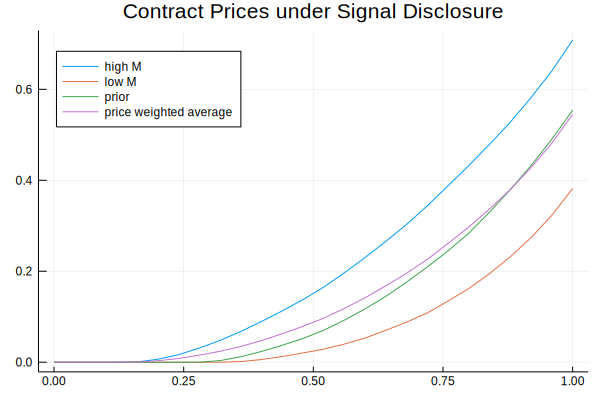

In [28]:
plot(contracts, [highEq.p, lowEq.p, mixedEq.p, (1/2 * (highEq.p + lowEq.p))], 
    labels = ["high M", "low M", "prior", "price weighted average"], 
    legend = :topleft,
    title = "Contract Prices under Signal Disclosure")

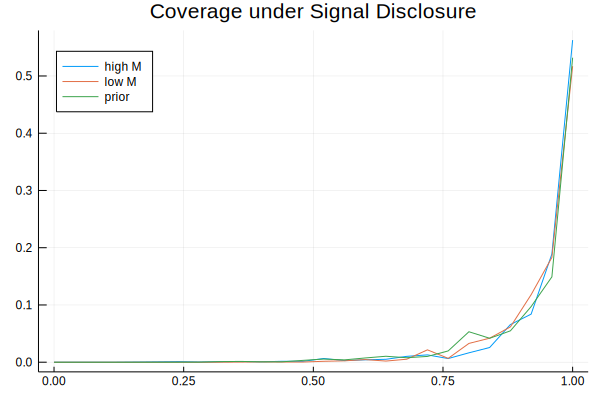

In [29]:
## Coverage
equilibria = [highEq.p, lowEq.p, mixedEq.p]
populations = [highPop, lowPop, mixedPop]
demands = [demand(i[1], i[2]) for i in zip(populations, equilibria)];

plot(contracts, [demands[1].D, demands[2].D, demands[3].D], 
    labels = ["high M", "low M", "prior"], 
    legend = :topleft,
    title = "Coverage under Signal Disclosure")

In [30]:
## Welfare
